In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

In [3]:
data = mpimg.imread('data/seismic.tif')

In [4]:
data.shape

(1036, 2350, 3)

In [5]:
mask = mpimg.imread('data/mask.tif')

In [6]:
mask.shape

(1036, 2350)

In [7]:
data = data[:,:,:1]/255
mask = (mask-mask.min())/(mask.max()-mask.min())

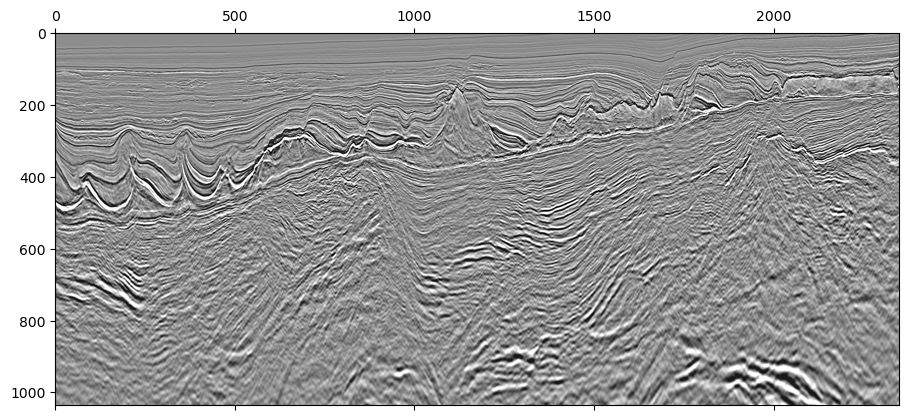

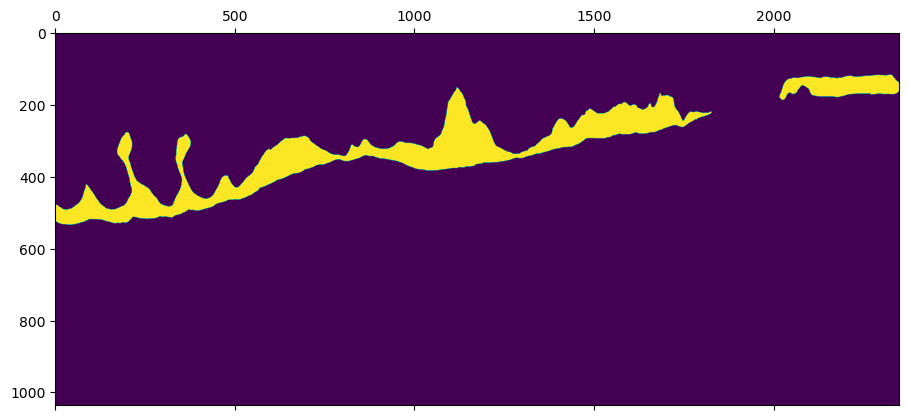

In [8]:
plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

In [9]:
mask[200, 500]

0.0

In [10]:
def patchify(data, mask, patch_num, dim):

  X = np.empty((patch_num, *dim))
  y = np.empty((patch_num,1))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not at the edge)   
      x_n = random.randint(dim[1]//2,x_max-dim[1]//2)
      t_n = random.randint(dim[0]//2,t_max-dim[0]//2)
      
      # Extract data patch around point   
      X[n,:,:,0] = data[t_n-dim[0]//2:t_n+dim[0]//2,x_n-dim[1]//2:x_n+dim[1]//2,0]
      
      # Note label of point (one-hot-encoding) zero for non salt and one for salt  
      if mask[t_n, x_n] >= 0.1:
        y[n] = 1
      else:
        y[n] = 0
      #y[n,1] = 1 - mask[t_n,x_n]

  return X, y

In [11]:
number_train = 5000                             # Number of training examples
number_test   = 1000                             # Number of validation examples
dim          = (64,64,1)                        # Size of examples

X_train, y_train = patchify(data[:,:1200], mask[:,:1200], number_train, dim)
X_test,   y_test   = patchify(data[:,1200:], mask[:,1200:], number_test, dim)

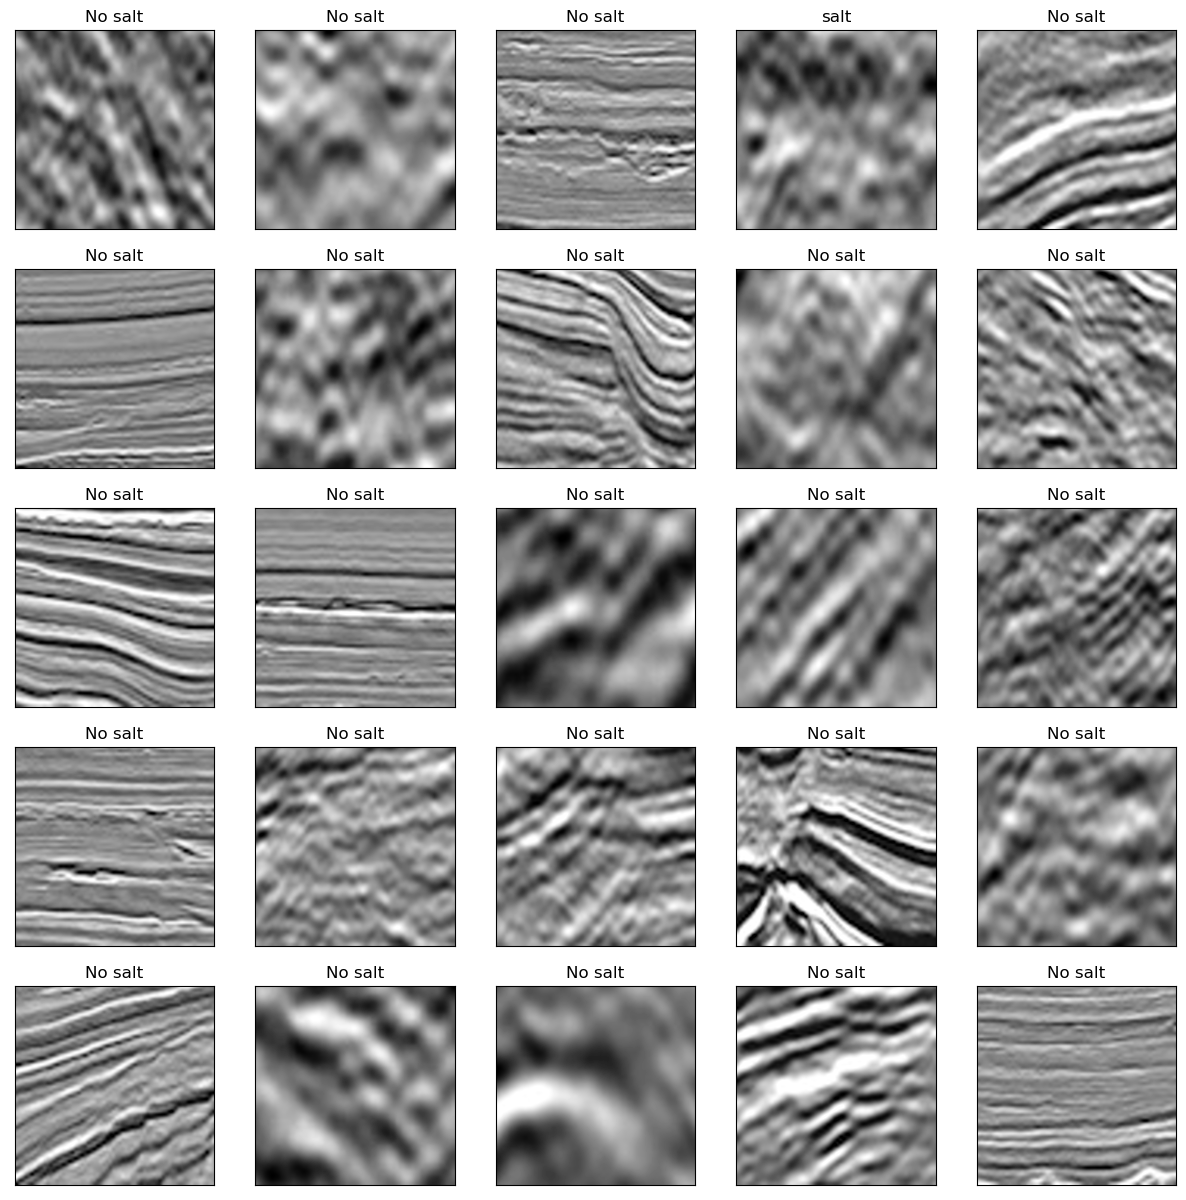

In [12]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))

k = 100
for n in range(5):
  for m in range(5):
    axs[n,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])
    k += 1
    if y_train[k,0] == 1:
      axs[n,m].set_title('salt')
    else:
      axs[n,m].set_title('No salt')

In [13]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [14]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.model = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Dropout(p=0.2),
                        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Dropout(p=0.2),
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2),
                        nn.Dropout(p=0.2),
                        nn.Flatten(start_dim=1),
                        nn.Linear(4096, 512, bias=True),
                        nn.ReLU(),
                        nn.Linear(512, 2, bias=True),
                        nn.Softmax())
    
    def forward(self, X):
        run = self.model(X)
        return run

X = torch.randn(1, 1, 64, 64).to(device)
model = BasicCNN().to(device)
y = model(X)
summary(model, (1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 16, 64, 64]          160
|    └─ReLU: 2-2                         [-1, 16, 64, 64]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 32, 32]          --
|    └─Dropout: 2-4                      [-1, 16, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 32, 32, 32]          4,640
|    └─ReLU: 2-6                         [-1, 32, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 32, 16, 16]          --
|    └─Dropout: 2-8                      [-1, 32, 16, 16]          --
|    └─Conv2d: 2-9                       [-1, 64, 16, 16]          18,496
|    └─ReLU: 2-10                        [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-11                   [-1, 64, 8, 8]            --
|    └─Dropout: 2-12                     [-1, 64, 8, 8]            --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 16, 64, 64]          160
|    └─ReLU: 2-2                         [-1, 16, 64, 64]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 32, 32]          --
|    └─Dropout: 2-4                      [-1, 16, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 32, 32, 32]          4,640
|    └─ReLU: 2-6                         [-1, 32, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 32, 16, 16]          --
|    └─Dropout: 2-8                      [-1, 32, 16, 16]          --
|    └─Conv2d: 2-9                       [-1, 64, 16, 16]          18,496
|    └─ReLU: 2-10                        [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-11                   [-1, 64, 8, 8]            --
|    └─Dropout: 2-12                     [-1, 64, 8, 8]            --
|    └─

In [15]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X.view(-1, 1, 64, 64))
        loss = criterion(y_pred, y.flatten().long())
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = y_pred.max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            y_pred = model(X.view(-1, 1, 64, 64))
            loss = criterion(y_pred, y.flatten().long())
            validation_loss += loss*X.size(0)
            y_pred = y_pred.max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            y_pred = model(X.view(-1, 1, 28, 28))
            y_pred = y_pred.max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [16]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 100
n_epochs = 10

In [17]:
seismic_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
seismic_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

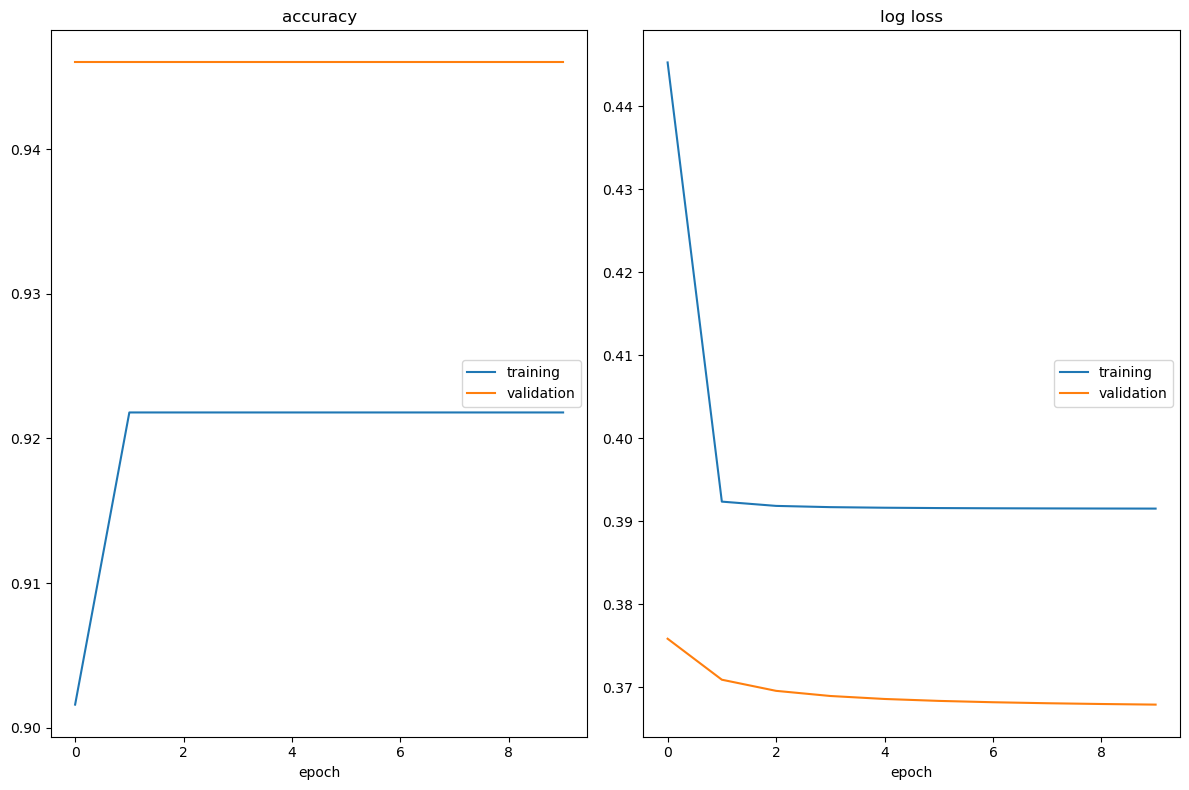

accuracy
	training         	 (min:    0.902, max:    0.922, cur:    0.922)
	validation       	 (min:    0.946, max:    0.946, cur:    0.946)
log loss
	training         	 (min:    0.392, max:    0.445, cur:    0.392)
	validation       	 (min:    0.368, max:    0.376, cur:    0.368)


In [18]:
def train_model(momentum):
  set_seed(seed)
  model = BasicCNN().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(seismic_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(seismic_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  #test_loader = DataLoader(, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(10):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(0.5)